In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from photutils import MMMBackground
from lightkurve.lightcurve import LightCurve
from astropy.stats import SigmaClip, sigma_clip
from scipy.interpolate import interp1d

import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

In [2]:
def redo_bkg(tpf_fn='fluxes_o1.npy'):
    a = np.load(tpf_fn)
    tpf = a[:,5:25,5:25]

    sigma=2.3
    sigma_clip = SigmaClip(sigma=sigma)
    bkg = MMMBackground(sigma_clip=sigma_clip)
    tpf_flux_bkg = bkg.calc_background(tpf, axis=(1, 2))
    
    bkg_tpf = np.zeros(tpf.shape)
    for i in range(len(tpf)):
        bkg_tpf = np.full((tpf.shape[1], tpf.shape[2]), tpf_flux_bkg[i])
    
    return bkg_tpf

def build_aperture(tpf):
    aperture = np.zeros(tpf.shape)
    aperture[:,9:12,9:12] = 1
    return aperture

In [3]:
a = np.load('fluxes_o1.npy')
ti, q = np.loadtxt('times_o1.txt', unpack=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  """


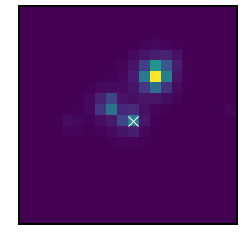

In [25]:
plt.imshow(a[100][5:25,5:25], vmax=10**7)
plt.xticks([])
plt.yticks([])
plt.plot(10,10,'wx',ms=10)
plt.savefig('/Users/arcticfox/Desktop/v1298tau.png', dpi=250, rasterize=True, bbox_inches='tight')

In [16]:
data = np.loadtxt('v1298_s43_o1.txt', unpack=True)
lk = LightCurve(time=data[0]-0.5, flux=data[1]).normalize()

<AxesSubplot:xlabel='Time [JD]', ylabel='Normalized Flux'>

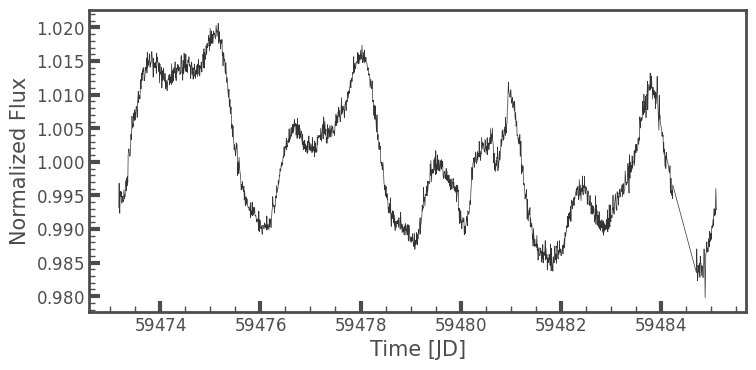

In [9]:
lk.plot()

## Setting up GP stuff

In [10]:
def setup_gp_data(time, flux, flux_err):
    x = np.ascontiguousarray(time, dtype=np.float64)
    y = np.ascontiguousarray(flux, dtype=np.float64)
    yerr = np.ascontiguousarray(flux_err, dtype=np.float64)

    mu = np.nanmean(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3 / mu

    return x, y, yerr

def gp_init_guess(x, y):
    results = xo.estimators.lomb_scargle_estimator(x, y, min_period=0.1, max_period=5,
                                               samples_per_peak=50)
    peak = results['peaks'][0]
    freq, power = results['periodogram']
    plt.plot(1/freq, power, 'k')  
    return peak

In [11]:
def run_gp(x, y, yerr, peak, mask=None):
    
    if mask is not None:
        x=x[mask]+0.0
        y=y[mask]+0.0
        yerr=yerr[mask]+0.0

    with pm.Model() as model:
        mean = pm.Normal('mean', mu=0.0, sigma=10.0)

        log_jitter = pm.Normal('log_jitter', mu=np.log(np.mean(yerr)), sigma=2.0)

        sigma = pm.InverseGamma('sigma',
                                **pmx.estimate_inverse_gamma_parameters(1.0,5.0))
        rho = pm.InverseGamma('rho',
                              **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))

        sigma_rot = pm.InverseGamma('sigma_rot',
                                    **pmx.estimate_inverse_gamma_parameters(1.0,5.0))

        log_period = pm.Normal('log_period', mu=np.log(peak['period']), sigma=2.0)
        period = pm.Deterministic('period', tt.exp(log_period))
        log_Q0 = pm.HalfNormal('log_Q0', sigma=2.0)
        log_dQ = pm.Normal('log_dQ', mu=0.0, sigma=2.0)
        f = pm.Uniform('f', lower=0.1, upper=1.0)

        kernel = terms.SHOTerm(sigma=sigma,
                              rho=rho,
                              Q=1.0/3.0)
        kernel += terms.RotationTerm(sigma=sigma_rot,
                                    period=period,
                                    Q0=tt.exp(log_Q0),
                                    dQ=tt.exp(log_dQ),
                                    f=f)

        gp = GaussianProcess(kernel,
                            t=x,
                            diag=yerr**2 + tt.exp(2*log_jitter),
                            mean=mean,
                            quiet=True)
        gp.marginal('gp', observed=y)
        pm.Deterministic('pred', gp.predict(y))

        map_soln = pmx.optimize()

    return map_soln

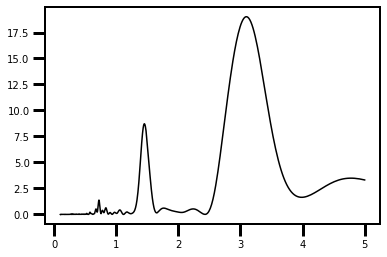

In [12]:
x, y, yerr = setup_gp_data(lk.time.value, lk.flux.value, np.full(len(lk.time), 0.01))
peak = gp_init_guess(x, y)

(59478.0, 59482.0)

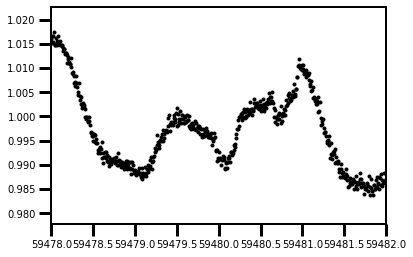

In [15]:
plt.plot(lk.time.value, lk.flux.value, 'k.')
plt.xlim(59478, 59482)

In [230]:
map_soln = run_gp(x, y, yerr, peak, mask=q)

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -5053.945998438889 -> -4558.944120229459


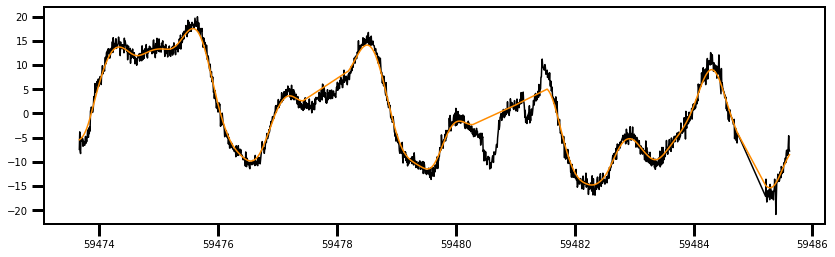

In [231]:
%matplotlib inline
plt.figure(figsize=(14,4))
plt.plot(x, y, 'k')
plt.plot(x[q], map_soln['pred'], color='darkorange');

## GP w/ transits

In [244]:


phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
        
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from David et al (2019)
        M_star_huang = 1.001, 0.039
        R_star_huang = 1.345, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star_huang[0], sd=M_star_huang[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star_huang[0], sd=R_star_huang[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)


        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()

order = c, d, b, e

In [17]:
dur =  ([4.66,5.59, 6.42, 7.45]*units.hour).to(units.day)
t0s = np.array([59478, 59481.3, 59477.7, 59480.6]) - 0.5
periods=[8.24958, 12.4032, 24.1396, 60]
rprs=[0.0381, 0.0436, 0.0700, 0.0611]
b=[0.34, 0.29, 0.46, 0.52]
texp = (10*units.min).to(units.day).value
#texp=np.full(len(b), texp)

NameError: name 'p_c' is not defined

In [247]:
transit_soln = gp_transit(x, y, yerr, t0s, periods, rprs)

optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Optimization terminated successfully.
logp: -5354.6238324548085 -> -5351.543546791687


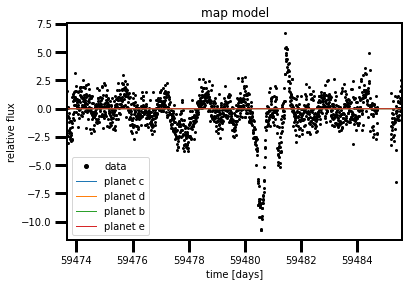

In [248]:
plt.plot(x, y, ".k", ms=4, label="data")
for i, l in enumerate("cdbe"):
    plt.plot(
        x, transit_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(x.min(), x.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")